# Intermediate Dataset Creation

The following notebook is used to create the intermediate dataset. This means training a CNN on a dataset, removing the fully-connected layers and producing the (flattened) output from the last convolutional layers. This output is then referred to as the intermediate dataset and saved for future reuse.

Import relevant packaces. Mainly the keras models are relevant in this step, as keras is used to train the convolutional neural network.

In [1]:
import json
import pandas as pd
import numpy as np

import os
import datetime
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.initializers import glorot_normal
from keras.applications import InceptionV3, Xception, InceptionResNetV2
from keras import Model

#dataset to use
from keras.datasets import cifar100

import math
from scipy.cluster.vq import whiten

import glob
import os


%matplotlib inline

/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


If necessary, images can be loaded from a local file system.

In [4]:
""" Load single image from filename


Parameters
----------
filename : string
    image to load

img_rows : int
    Number of rows of pixels

img_cols : int
    number of columns of pixels

plot : Boolean
    boolean value whether loaded image should be output

"""

def load_image(filename, img_rows=100, img_cols=100, plot=True):
    try:
        # load an image in PIL format
        original = load_img(filename, target_size=(img_rows, img_cols))

        # convert the PIL image to a numpy array
        # IN PIL - image is in (width, height, channel)
        # In Numpy - image is in (height, width, channel)
        numpy_image = img_to_array(original)

        # Convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # Thus we add the extra dimension to the axis 0.
        image_batch = np.expand_dims(numpy_image, axis=0)
        if plot: plt.imshow(np.uint8(image_batch[0]))
        return image_batch
    except IOError:
        # image_list.remove(filename)
        print("removed")
        return np.array([])

In [1]:
""" *** CURRENTLY NOT IN USE BECAUSE fetch_data_from_classes DOES THE SAME ***
Load multiple images from folder path


Parameters
----------
file_path : string
    path to get input data from

img_rows : int
    number of pixel rows

img_cols : int
    number of pixel columns

cutoff : int
    number of samples to exclude from file list by defining a cutoff point in array 
    (default: -1 (last entry) -> 0 examples to remove)

"""
def fetch_data (file_path, img_rows=100, img_cols=100, cutoff=-1):
    # 2. Auto-iterate using the query syntax
    #    https://developers.google.com/drive/v2/web/search-parameters
    
    # file_list = glob.glob("./data/input/" + file_path + "/*.JPEG")
    file_list = glob.glob(file_path + "/*.JPEG")
  
    final_images = []
    batches = []
    for f in file_list[0:cutoff]:
        curr_image = load_image(f, img_rows, img_cols)
        if curr_image.size != 0:
            final_images.append(f)
            batches.append(curr_image)
    batches = [b[0] for b in batches]
    return final_images, np.array(batches)

In [6]:
""" Get label information corresponding to loaded images and load multiple images from folder path


Parameters
----------
file_path : string
    path to get input data from

img_rows : int
    number of pixel rows

img_cols : int
    number of pixel columns

classes : list
    list of classes to include 

label_file : string
    file to find corresponding labels to images

"""

def fetch_data_from_classes (file_path, img_rows=100, img_cols=100, classes = list(range(1,1001)), label_file = "351_Data/ILSVRC2012_Validation/labels/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"):

    labels = np.array(pd.read_csv(label_file, header=None, names=["Class"], engine='python'))
    # inclass_labels = [el for ind,el in enumerate(labels) if el in classes]
    indices = [ind for ind,el in enumerate(labels) if el in classes]
    inclass_labels = labels[np.sort(indices)]
    
    file_list = glob.glob(file_path + "/*.JPEG")
    file_list = np.sort([f for f in file_list if int(f.split("_")[-1].split(".JPEG")[0]) - 1 in indices])
    
    final_images = []
    batches = []
    for f in file_list:
        curr_image = load_image(f, img_rows, img_cols,True)
        if curr_image.size != 0:
            final_images.append(f)
            batches.append(curr_image)
    batches = [b[0] for b in batches]
    return final_images, np.array(batches),inclass_labels

In [ ]:
""" Format data in pieces instead of all at once


Parameters
----------
...

"""

def format_data_in_pieces(x_train, x_test, size=100):
    train = np.array([])
    test = np.array([])
    ind = 0
    while True:
        a,b = format_data(x_train[ind : ind + size], x_test[ind : ind + size])
        np.append(train, np.array(a))
        np.append(test, np.array(b))
        
        if ind + size>=max(len(x_train), len(x_test)):
            np.append(train, np.array(x_train[ind : ]))
            np.append(test, np.array(x_test[ind : ]))
            break
        ind = ind + size
        
    return train,test

In [8]:
""" Squash the pixel values to be between 0 and 1


Parameters
----------
image : array, e.g., numpy array

"""

def general_preprocessing(image):    
    return image/255.

In [9]:
""" Format the input data and apply preprocessing on them


Parameters
----------
x_train : array, e.g., numpy array
    training data to transform
x_test : array, e.g., numpy array
    test data to transform
preprocessing_function : function
    function to apply on datasets for preprocessing
"""

def format_data(x_train, x_test, preprocessing_function = general_preprocessing):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = preprocessing_function(x_train)
    x_test = preprocessing_function(x_test)
    return x_train, x_test

Does Whitening work when it is done independently on x_train and x_test? (e.g., should the same whitening factor be used on x_test as on x_train)

In [10]:
""" Filter dataset by classes, e.g., to only use a subset of classes


Parameters
----------
X : array, e.g., numpy array
    input data
y : list
    targets
classes : list
    Classes to include in benchmark

"""

def filter_for_classes(X, y, classes):
    mask = np.isin(y, classes)
    mask = mask.reshape(len(mask))
    return X[mask], y[mask]

In [11]:
""" Whiten the data


Parameters
----------
x_train : array, e.g., numpy array
    training input data
    
x_test : array, e.g., numpy array
    testing input data
    
"""

def whiten_data(x_train, x_test):
    X = np.append(x_train, x_test, axis=0)
    X_white = whiten(X).reshape(X.shape)
    x_train_white = X_white[0:x_train.shape[0]]
    x_test_white = X_white[x_train.shape[0]:x_train.shape[0]+x_test.shape[0]]
    return x_train_white, x_test_white

In [12]:
""" Create the output files to save intermediate datasets for further use


Parameters
----------
x_train : array, e.g., numpy array
    training input data
    
x_test : array, e.g., numpy array
    testing input data

y_train : list
    training target data

y_test : list
    test target data

prefix : string
    prefix to add to output file name

suffix : string
    suffix to add to output file name

"""

def create_output_files (x_train, x_test, y_train, y_test, prefix, suffix = ""):
    for model_ind, model in enumerate(models):
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i,preds in enumerate(pred_train)])
        pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i,preds in enumerate(pred_test)])
        path = input_path + "Intermediate/" + prefix + "/" + model_names[model_ind]
        if not os.path.exists(path):
            os.makedirs(path)
        save_data(path + "/train" + suffix, pred_train_with_target)
        save_data(pred_test_with_target)
        

In [13]:
""" Function to save an individual dataset.
If the dataset is too large, it is split into multiple dataset. This step is done recursively,
such that if a dataset is still too large after the first split, another split of each half is
performed (except statement)


Parameters
----------
path : string
    path to save data

data : array, e.g., numpy array
    data to save

suffix : int
suffix to add to file name

"""

def save_data (path,data,suffix = 0):
    # try to save dataset --> will throw error if dataset to save is too large
    try:
        np.save(path + "_" + str(suffix), data)
        return suffix
    # catch if dataset is too large and recursively save half the dataset
    except:
        data0,data1 = split_data(data)
        suffix = save_data(path,data0,suffix)
        return save_data(path,data1,suffix + 1)

In [14]:
""" Split a dataset into two halves


Parameters
----------
data : array, e.g., numpy array
    dataset to split in halves

"""

def split_data (data):
    return data[:int(data.shape[0]/2)], data[int(data.shape[0]/2):]

In [15]:
"""  *** CURRENTLY NOT IN USE ***
Define a pipeline to run input data through and create output files


Parameters
----------
class_start : int
    lower class boundary

class_end : int
    higher class boundary

prefix : string
    prefix to add to filename

"""

def dev_pipeline(class_start, class_end, prefix):
    final_images, batches,curr_labels = fetch_data_from_classes(input_path + "images", img_rows, img_cols, classes = list(range(class_start,class_end)))
    x_train, x_test, y_train, y_test = train_test_split(batches, curr_labels, test_size=0.25)
    x_train, x_test = format_data(x_train, x_test)
    classes_to_retain = range(class_start,class_end)
    num_classes = len(classes_to_retain)
    x_train, y_train = filter_for_classes(x_train, y_train, classes_to_retain)
    x_test, y_test = filter_for_classes(x_test,y_test,classes_to_retain)
    x_train, x_test = whiten_data(x_train,x_test)
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)
    suffix = "_{}-{}".format(class_start, class_end)
    create_output_files(x_train, x_test, y_train, y_test, prefix, suffix)

In [16]:
""" *** CURRENTLY NOT IN USE ***
Run multiple pieces of input dataset sequentially to reduce workload


Parameters
----------
prefix : string
    prefix to add to file_name

class_chunk_size : int
    classes to process per run

label_file : string
    file path where correct labels are stored

"""

def run_all(prefix, class_chunk_size=10, label_file = "351_Data\ILSVRC2012_Validation\labels\ILSVRC2012_devkit_t12\data\ILSVRC2012_validation_ground_truth.txt"):
    labels = np.array(pd.read_csv(label_file, header=None, names=["Class"]))
    num_classes = len(np.unique(labels))
    start_ind = min (np.unique(labels))
    # path = input_path + "Intermediate\\" + prefix + "\\" + model_names[model_ind]
    # if not os.path.exists(path):
    #    os.makedirs(path)

    while True:
        dev_pipeline(start_ind, start_ind + class_chunk_size, prefix)
        if start_ind+ class_chunk_size>max(np.unique(labels)):
            dev_pipeline(start_ind, max(np.unique(labels)) + 1, prefix)
            break
        start_ind = start_ind + class_chunk_size    

In [2]:
""" save input images in folder structure and output them


Parameters
----------
images : array, e.g. numpy array
    images to show

classes : list
    [not used]

prefix : string
    prefix to add to output name

suffix : string
    suffix to add to output name


"""

def show_image_classes(images, classes, prefix, suffix=""):
    for cl in np.unique(y_train):
        for ind,el in enumerate(y_train):
            if el == cl:
                class_pos = ind
                break
        plt.figure()
        plt.imshow(np.uint8(x_train[class_pos]))
        path = "353_Sample_Images/" + prefix + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + input_path.split("/")[1].split("_")[0] + "_" + str(cl) + "_sample_image_" + suffix)

In [19]:
"""Preprocesses a numpy array encoding a batch of images.
This function applies the "Inception" preprocessing which converts
the RGB values from [0, 255] to [-1, 1]. Note that this preprocessing
function is different from `imagenet_utils.preprocess_input().

- incepresnet from https://github.com/fchollet/deep-learning-models/blob/master/inception_resnet_v2.py
- xception from https://github.com/fchollet/deep-learning-models/blob/master/xception.py
- inception v3 from https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py

Parameters
----------
    x: a 4D numpy array consists of RGB values within [0, 255].

# Returns
    Preprocessed array.
"""

def preprocess_input(x):

    x /= 255.
    x -= 0.5
    x *= 2.
    return x

## Data Handling

Everything from class_start till class_end is included in the data (excluding class_end)

The original dataset contains 1000 classes so this will be down-sampled to 100 classes

In [20]:
class_start = 1
class_end = 101

classes_to_retain = range(class_start,class_end)
num_classes = len(classes_to_retain)

Define input path where images are stored

In [21]:
input_path = "351_Data/ILSVRC2012_Validation/"

Define dimension that images should have

In [22]:
img_rows, img_cols = 299, 299

Get classification images and corresponding labels

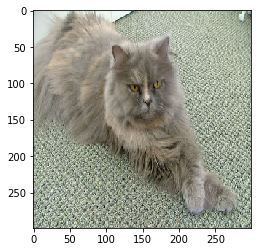

In [23]:
final_images, batches, curr_labels = fetch_data_from_classes(input_path + "images", img_rows, img_cols, classes = list(range(class_start,class_end)))

Split dataset into train and test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(batches, curr_labels, test_size=0.25)

Make output classes categorical (one-hot encoded)

In [ ]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
# suffix = "_{}-{}".format(class_start, class_end)

### Data Exploration

Get images for a given class integer, e.g. class integer 30

In [24]:
class_int = 30
class_n_pos = [ind for ind,el in enumerate(curr_labels) if el == class_int]

Print out all images of that class to manually check if the data loading process worked (images should display similar concepts)

/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


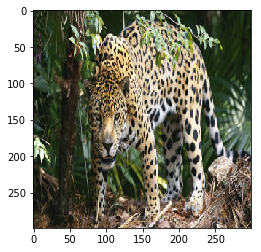

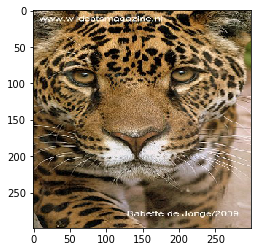

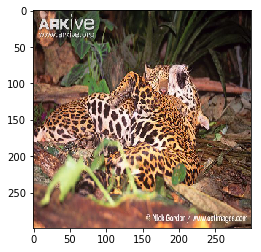

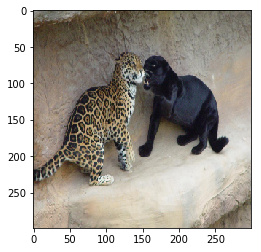

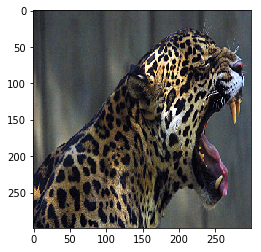

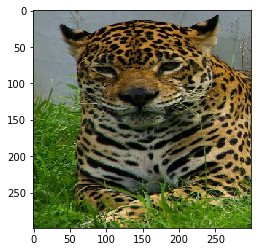

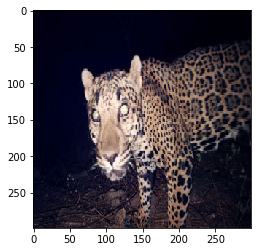

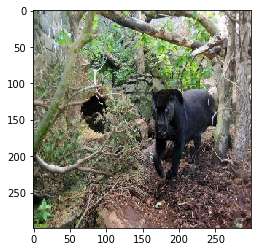

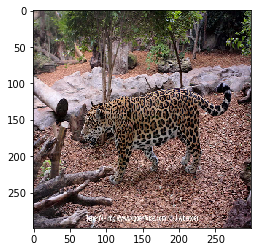

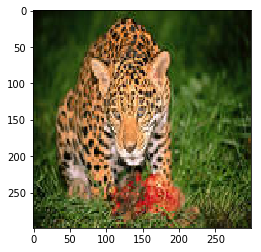

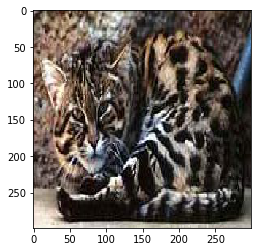

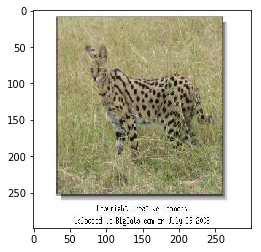

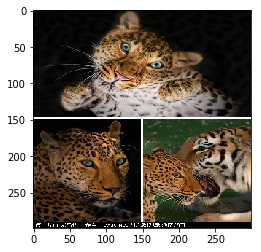

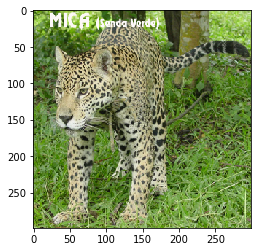

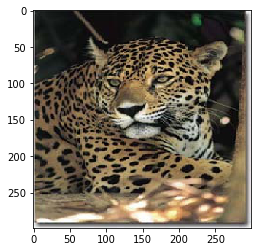

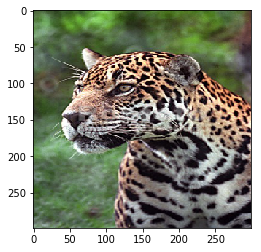

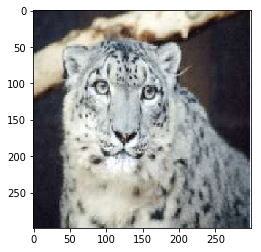

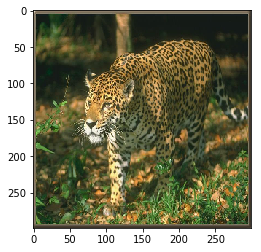

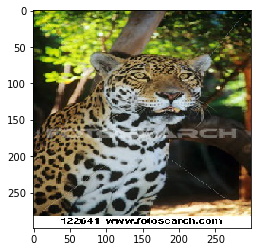

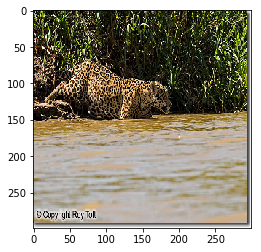

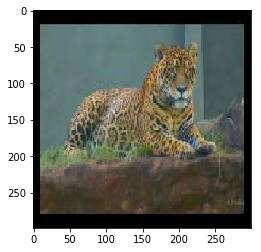

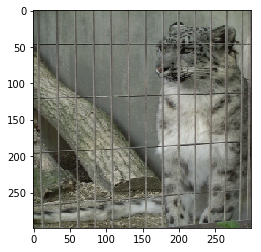

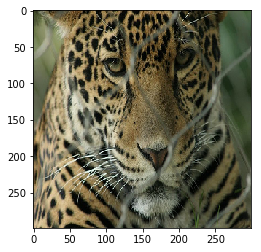

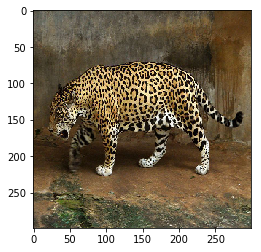

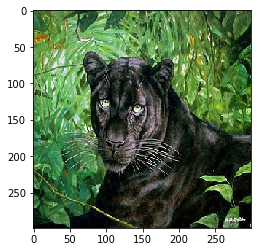

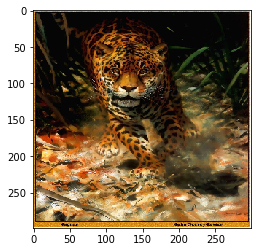

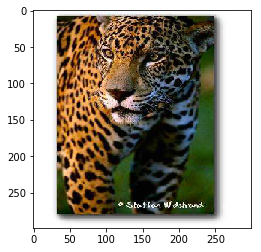

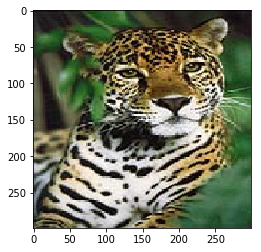

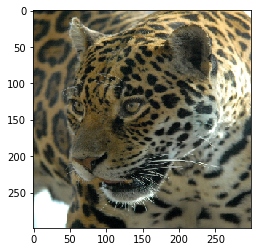

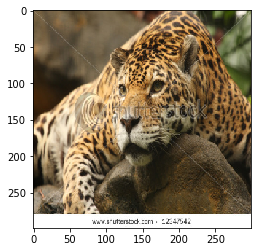

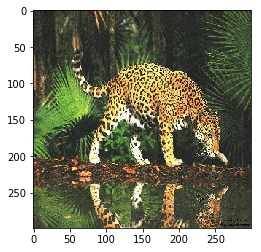

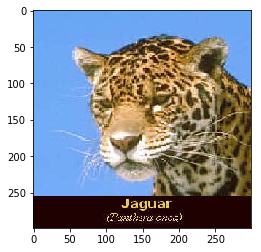

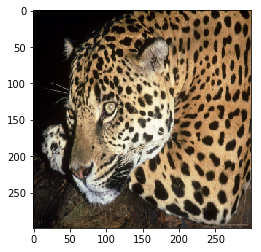

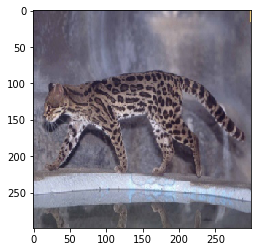

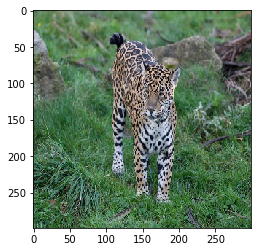

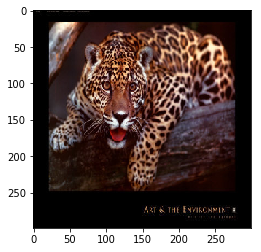

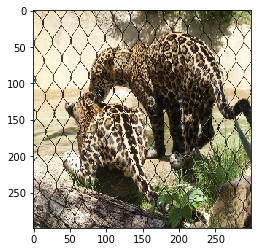

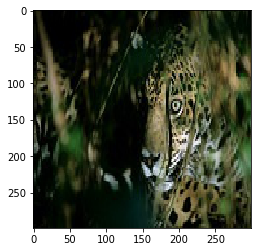

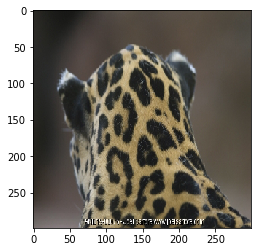

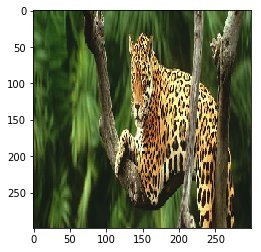

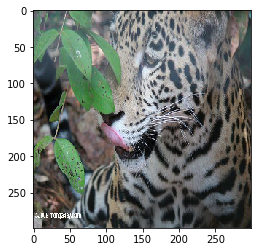

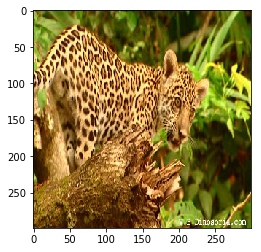

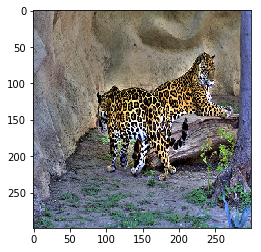

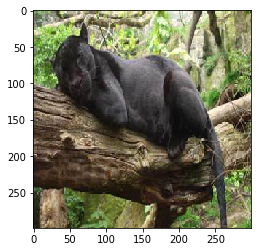

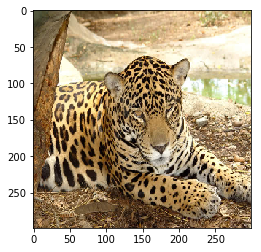

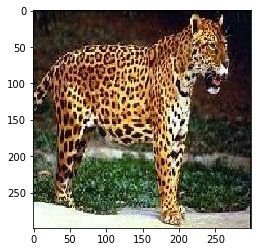

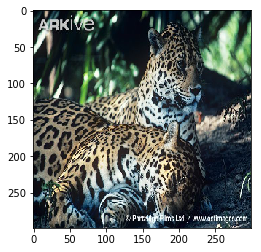

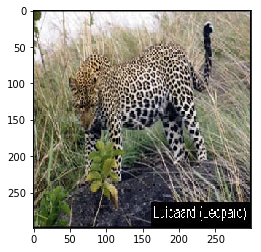

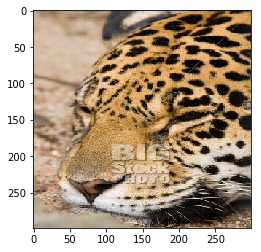

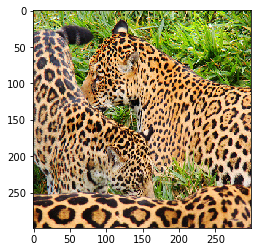

In [26]:
for img in class_n_pos:
    plt.figure()
    plt.imshow(np.uint8(batches[img]))

Save input images to file and display them (before preprocessing)

In [ ]:
show_image_classes(x_train,y_train,prefix,"raw")

In [25]:
models = []
model_names = []
input_shape = batches[0].shape

### Image Preprocessing

Preprocess images with previously defined method

In [3]:
x_train, x_test = format_data(x_train, x_test,preprocess_input)

NameError: name 'format_data' is not defined

## Model Development

Load pretrained Inception V3, Xception and InceptionResNet V2 models.
Save models in array "models"

In [26]:
incpv3_model = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
models.append(incpv3_model)
model_names.append("InceptionV3")

In [27]:
xcep_model = Xception(include_top=False, input_shape=input_shape, weights='imagenet')
models.append(xcep_model)
model_names.append("Xception")

In [28]:
incepresnet_model = InceptionResNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
models.append(incepresnet_model)
model_names.append("Inception ResNet")

Print out the parameters of each model

In [29]:
for model in models:
    print(model.count_params())

21802784
20861480
54336736


Remove the final classification layer from the models and replace it with a flattening layer

In [31]:
for ind, model in enumerate(models):
    output = model.layers[-1].output
    output_ = Flatten()(output)
    # output = Dense(output_dim=1000, activation='relu')(output) # your newlayer Dense(...)
    models[ind] = Model(model.input, output_)

Get date to add timestamp to output

In [32]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

Create output files

In [41]:
suffix = ""

for model_ind, model in enumerate(models):
    path = input_path + "Intermediate/" + prefix + "/" + model_names[model_ind]
    if not os.path.exists(path):
        os.makedirs(path)
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i,preds in enumerate(pred_train)])
    pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i,preds in enumerate(pred_test)])
    save_data(path + "/train" + suffix,pred_train_with_target)
    save_data(path + "/test" + suffix,pred_test_with_target)